<a href="https://colab.research.google.com/github/jpsicilia/chess_data_lab/blob/main/chess_data_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importar Librerias

In [42]:
import csv
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
def limpiar_csv_con_csv_reader(ruta_entrada, ruta_salida):
    with open(ruta_entrada, 'r', encoding='utf-8') as infile, \
         open(ruta_salida, 'w', encoding='utf-8', newline='') as outfile:

        reader = csv.reader(infile)
        writer = csv.writer(outfile)

        num_columnas = None
        filas_validas = 0
        filas_saltadas = 0

        for i, row in enumerate(reader):
            if num_columnas is None:
                num_columnas = len(row)
                writer.writerow(row)  # Escribo cabecera
            else:
                if len(row) == num_columnas:
                    writer.writerow(row)
                    filas_validas += 1
                else:
                    filas_saltadas += 1
                    print(f"Salteando fila {i+1} por cantidad incorrecta de columnas ({len(row)} vs {num_columnas})")

    print(f"Filas válidas: {filas_validas}")
    print(f"Filas saltadas: {filas_saltadas}")

ruta_original = 'games_wgm.csv'
ruta_limpia = 'games_wgm_limpio.csv'

limpiar_csv_con_csv_reader(ruta_original, ruta_limpia)

df = pd.read_csv(ruta_limpia)
print(df.shape)


Filas válidas: 304767
Filas saltadas: 0
(304767, 15)


In [44]:
df=pd.read_csv('games_wgm_limpio.csv')

In [45]:
df.isna().sum()

,0
game_id,0
game_url,0
pgn,3473
time_control,0
end_time,0
rated,0
time_class,0
rules,0
wgm_username,0
white_username,0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304767 entries, 0 to 304766
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   game_id         304767 non-null  object
 1   game_url        304767 non-null  object
 2   pgn             301294 non-null  object
 3   time_control    304767 non-null  object
 4   end_time        304767 non-null  object
 5   rated           304767 non-null  bool  
 6   time_class      304767 non-null  object
 7   rules           304767 non-null  object
 8   wgm_username    304767 non-null  object
 9   white_username  304767 non-null  object
 10  white_rating    304767 non-null  int64 
 11  white_result    304767 non-null  object
 12  black_username  304767 non-null  object
 13  black_rating    304767 non-null  int64 
 14  black_result    304767 non-null  object
dtypes: bool(1), int64(2), object(12)
memory usage: 32.8+ MB


In [50]:
def extract_opening(pgn_text):
    # Caso 1: Datos faltantes (NaN)
    if pd.isna(pgn_text):
        return pd.Series([pd.NA, pd.NA])  # Usamos pd.NA para datos faltantes

    # Caso 2: PGN existe pero no tiene info de apertura
    eco = re.search(r'\[ECO "(.*?)"\]', pgn_text)
    eco = eco.group(1) if eco else None

    eco_url = re.search(r'\[ECOUrl "(.*?)"\]', pgn_text)
    eco_url = eco_url.group(1) if eco_url else None

    # Caso 3: Apertura realmente desconocida (existe PGN pero no tiene ECO)
    if not eco and not eco_url:
        return pd.Series(["Unknown", "Unknown"])

    # Caso 4: Apertura conocida
    opening_name = eco_url.split("/")[-1].replace("-", " ").capitalize() if eco_url else "Unknown"

    return pd.Series([eco if eco else "Unknown", opening_name])

# Aplicamos la función
df[['eco_code', 'opening_name']] = df['pgn'].apply(extract_opening)

# Para el análisis, filtramos los valores NA
df_valid_openings = df.dropna(subset=['opening_name'])

<ipython-input-51-0125be52ffc1>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




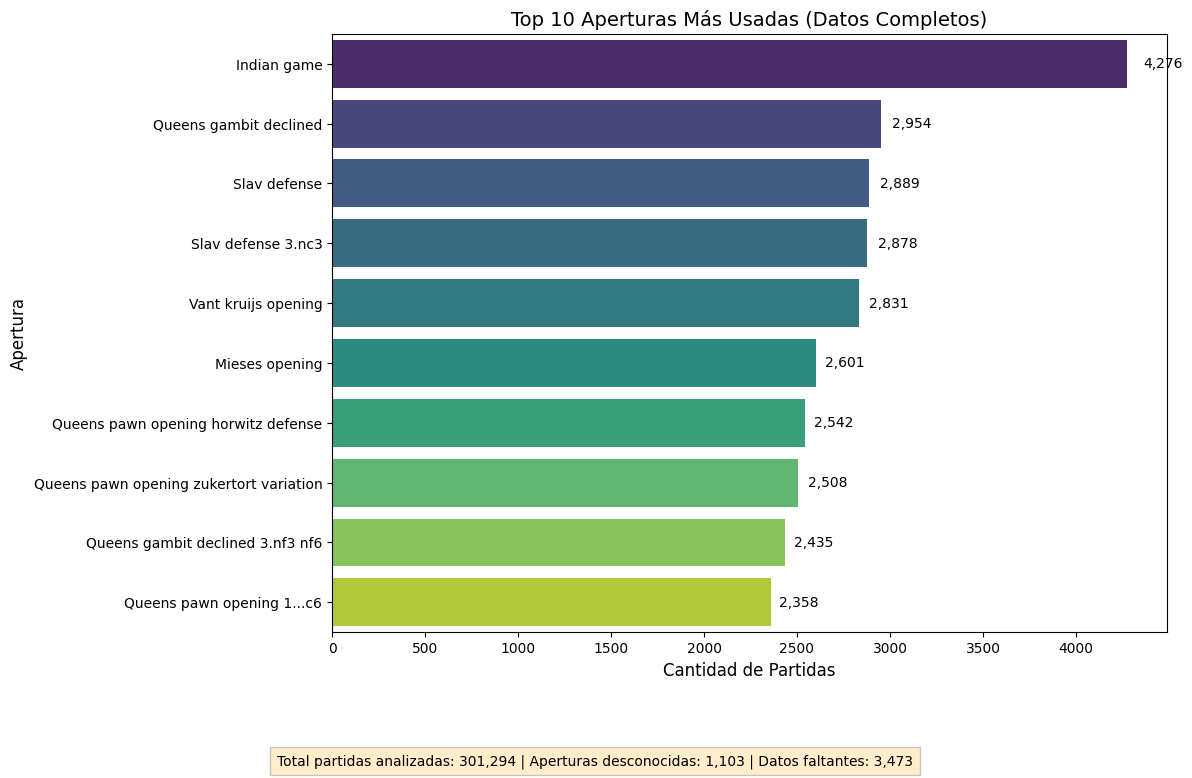

In [51]:
plt.figure(figsize=(12, 7))

# Filtramos aperturas desconocidas y missing values
top_openings = df_valid_openings[df_valid_openings['opening_name'] != "Unknown"]['opening_name'].value_counts().head(10)

ax = sns.barplot(x=top_openings.values,
                 y=top_openings.index,
                 palette='viridis',
                 order=top_openings.index)

# Mejoras visuales
plt.title('Top 10 Aperturas Más Usadas (Datos Completos)', fontsize=14)
plt.xlabel('Cantidad de Partidas', fontsize=12)
plt.ylabel('Apertura', fontsize=12)

# Añadir valores exactos
for i, v in enumerate(top_openings.values):
    ax.text(v + 0.02*v, i, f"{v:,}", color='black', va='center')

# Información adicional en el gráfico
total_games = len(df_valid_openings)
unknown_games = len(df[df['opening_name'] == "Unknown"])
missing_games = df['opening_name'].isna().sum()

plt.figtext(0.5, -0.1,
           f"Total partidas analizadas: {total_games:,} | "
           f"Aperturas desconocidas: {unknown_games:,} | "
           f"Datos faltantes: {missing_games:,}",
           ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.tight_layout()
plt.show()